In [1]:
%reload_ext autoreload
%autoreload 2
%load_ext rpy2.ipython

from online_sorter_qtui import spike_data
from pyneurode.spike_sorter import *
import numpy as np 
import pickle
from sklearn import metrics
from tqdm.notebook import tqdm
import seaborn as sns

import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw

from sklearn import *

from palettable.colorbrewer.qualitative import Dark2_4 as p4color

from utils import *

%R require(ggplot2)
%R require(repr)

C:\Users\teristam\Anaconda3\envs\oeEnv\lib\site-packages\rpy2\robjects\packages.py:366: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  "The symbol '%s' is not in this R namespace/package." % name
C:\Users\teristam\Anaconda3\envs\oeEnv\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\teristam\Anaconda3\envs\oeEnv\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
R[write to console]: Loading required package: ggplot2

R[write to console]: Loading required package: repr



array([1], dtype=int32)

In [2]:
# load data
data_list = []
segment_count = 0
with open('data/data_packets_M2_D23_2.pkl','rb') as f:
    while True:
        try:
            data_list.append(pickle.load(f))
            segment_count +=1
        except EOFError:
            break
    
    print(f'Reached end. Total segment: {segment_count}')


Reached end. Total segment: 18260


In [3]:
Fs = 30000
spikes_data = [d['spike'] for d in data_list if 'spike' in d.keys()]
df = makeSpikeDataframe(spikes_data)
df.head()

spike_waveform  \
0  [-27.886637, -33.836754, -28.370417, -17.97498...   
1  [4.702097, 9.149773, 15.755678, 13.68521, 3.61...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [2.9395258, 5.6907673, 15.705636, 20.368834, 1...   
4  [-25.959833, -39.288464, -36.88405, -26.13552,...   

                                                time  electrode_ids  \
0  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...              1   
1  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...              1   
2  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...              3   
3  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...              2   
4  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...              1   

                                         channel_ids  spike_id  timestamps  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...         0      210291  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...         1      210874  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...         2      235969  
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...         3      236735  
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...         4      237340

(27, 9217280)
209280


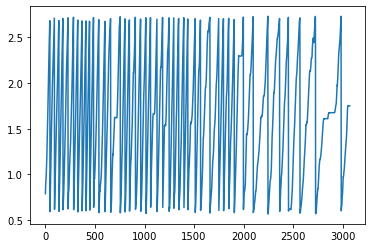

In [4]:
# collect the animal position
time_bin = 0.1
adc_data = [d['data'] for d in data_list if 'data' in d]
adc_data = np.concatenate(adc_data,1)
print(adc_data.shape)
start_timestamp = data_list[1]['data_timestamp']
print(start_timestamp)

# Extract and time-bin the data
segment_size = int(Fs*time_bin)
position, _ = simpleDownSample(adc_data[20,:,None], segment_size)
plt.plot(position)

In [7]:
num2sort = 2000
df_ref, df_online,template_cluster_id = sort_spikes_online(df.iloc[:num2sort], df.iloc[num2sort:])

(9, 3088)


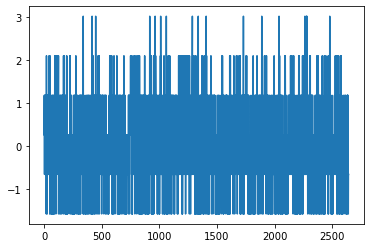

In [9]:
# make firing rate array
Fs = 30000
time_bin = 0.1
time_bin_start=0
spike_time = (df_online.timestamps.values - start_timestamp)/Fs #shift timestamp
bins = np.arange(time_bin_start, spike_time.max(), time_bin )
spk_train, skp_time_event=sort2spiketrain(template_cluster_id, df_online.label_tm, spike_time, bins)
print(spk_train.shape)

# need to find the corresponding bin in position from the first
first_spike = spike_time[0]
online_sorting_start_idx = np.argmin(np.abs(first_spike-bins))
spk_train = spk_train[:,online_sorting_start_idx:]

#normalize the firing rate
scaler =preprocessing.StandardScaler()
norm_spiketrain = scaler.fit_transform(spk_train.T)
plt.plot(norm_spiketrain[:,0])

### Train decoder

In [10]:
norm_pos_online = position[online_sorting_start_idx:] #skip the beginning where spike is still being collected

data_length = min(norm_spiketrain.shape[0], norm_pos_online.shape[0])
norm_spiketrain = norm_spiketrain[:data_length,:]
norm_pos_online = norm_pos_online[:data_length]

norm_pos_online = np.round((norm_pos_online-norm_pos_online.min())/(norm_pos_online.max()-norm_pos_online.min())*200)


In [12]:
polyFeatures = preprocessing.PolynomialFeatures(2).fit(norm_spiketrain)
poly_spiketrain = polyFeatures.transform(norm_spiketrain)
lasso = linear_model.Lasso(alpha=0.1).fit(poly_spiketrain,norm_pos_online)
featureName = np.array(polyFeatures.get_feature_names())
idx = np.argsort(-lasso.coef_**2) #sorted feature index, descending
sortedFeatureName = featureName[idx]
print(sortedFeatureName)

['x5' 'x0' 'x7' 'x2' 'x0 x5' 'x6 x7' 'x6' 'x4' 'x4 x6' 'x1' 'x2 x3'
 'x6 x8' 'x7^2' 'x2^2' 'x3 x5' 'x4 x8' 'x4 x7' 'x3 x8' 'x1 x5' 'x5 x6'
 'x5^2' 'x0 x6' 'x3 x6' 'x2 x4' 'x2 x5' 'x4^2' 'x2 x8' 'x1 x3' 'x0 x4'
 'x4 x5' 'x0 x1' 'x2 x7' 'x3 x7' 'x0 x8' 'x1^2' 'x8' 'x6^2' 'x1 x2'
 'x3 x4' 'x0 x2' 'x3^2' 'x8^2' 'x5 x7' 'x7 x8' 'x1 x7' 'x1 x8' 'x0 x7'
 'x2 x6' 'x1 x6' 'x1 x4' 'x5 x8' 'x0 x3' 'x0^2' 'x3' '1']


[[1.         0.03981048]
 [0.03981048 1.        ]]


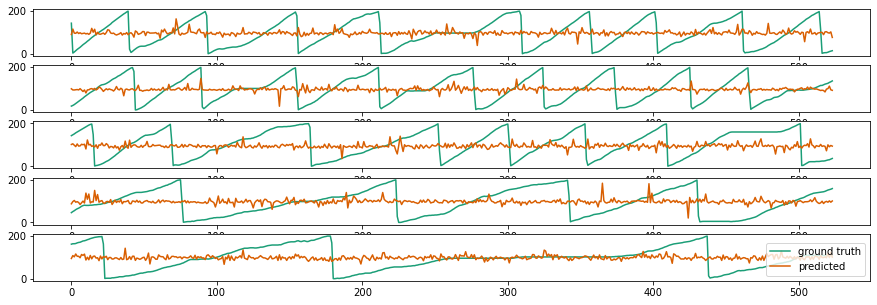

In [13]:
predicted = model_selection.cross_val_predict(lasso,poly_spiketrain,norm_pos_online,cv=5)
bestCoeff = np.corrcoef(norm_pos_online.squeeze(),predicted)
print(bestCoeff)
stripplot(norm_pos_online,predicted);

In [137]:
results = crossValidate(lasso, poly_spiketrain,norm_pos_online)
print(results)
print(np.mean(np.abs(results['test_explained_variance'])))

{'fit_time': array([0.00698113, 0.00598383, 0.00498629, 0.00498652, 0.00398946,
       0.00598407, 0.00648785, 0.00498676, 0.00498629, 0.00498676]), 'score_time': array([0.        , 0.        , 0.        , 0.        , 0.0009973 ,
       0.0009973 , 0.        , 0.00099778, 0.00099754, 0.        ]), 'test_explained_variance': array([ 0.01891995,  0.04407111,  0.03183578, -0.00175919, -0.03758054,
       -0.02887609, -0.0162663 ,  0.02293296, -0.02533907,  0.00705958]), 'test_r2': array([ 0.00866292,  0.04375511,  0.03166155, -0.00513817, -0.03971799,
       -0.05314133, -0.02009755,  0.01573534, -0.04653985, -0.00910928])}
0.023464058447530335


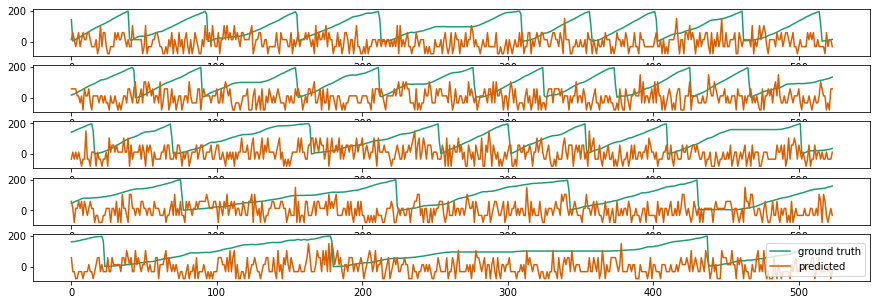

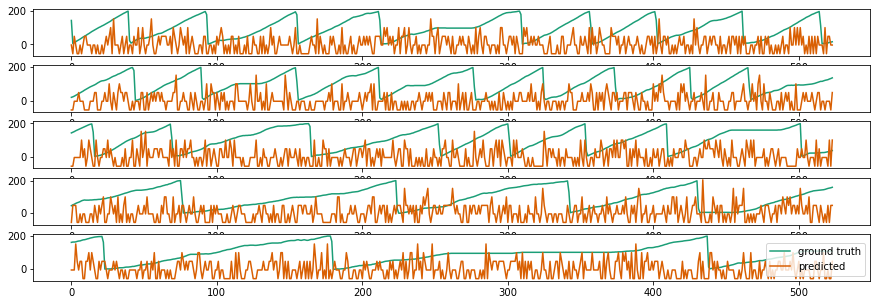

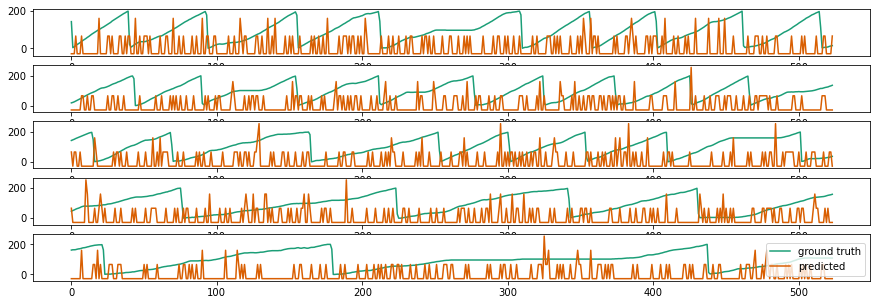

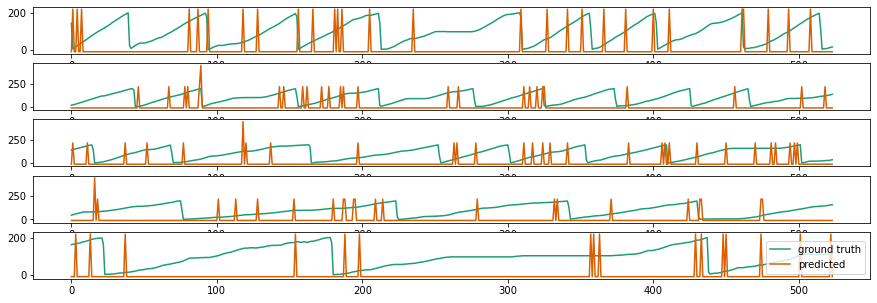

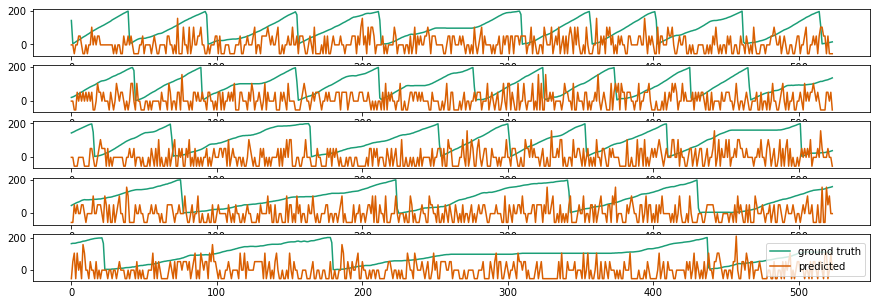

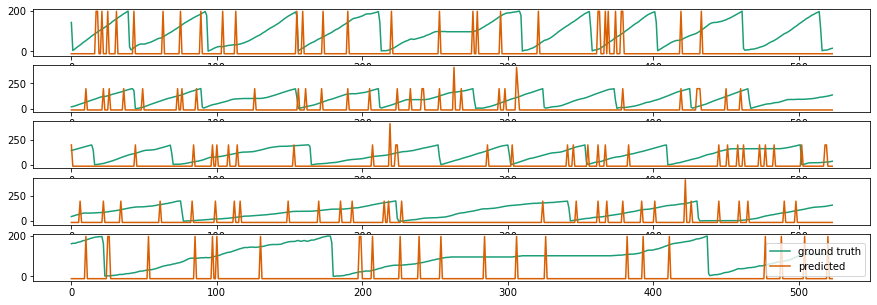

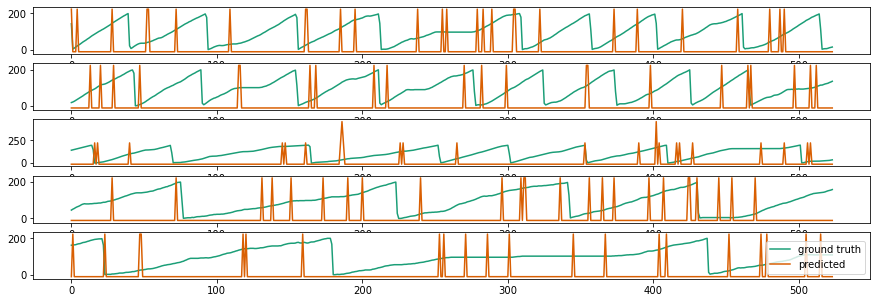

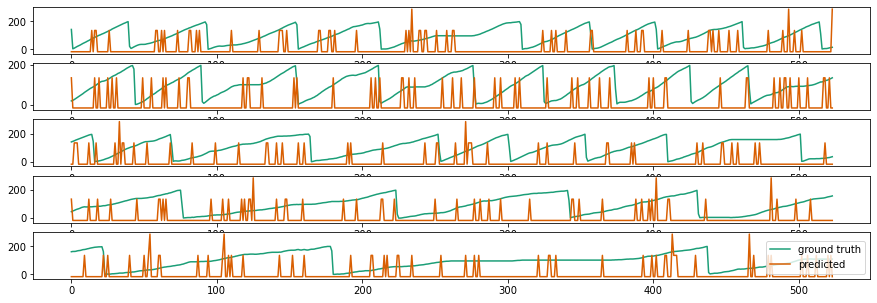

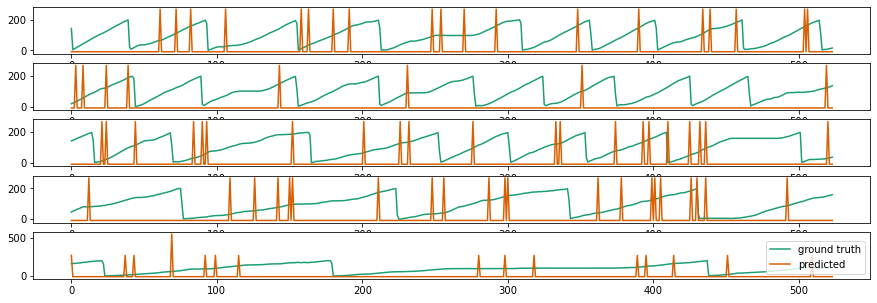

In [14]:
for i in range(norm_spiketrain.shape[1]):
    stripplot(norm_pos_online,norm_spiketrain[:,i]*50);

### use mountainsort for decoding

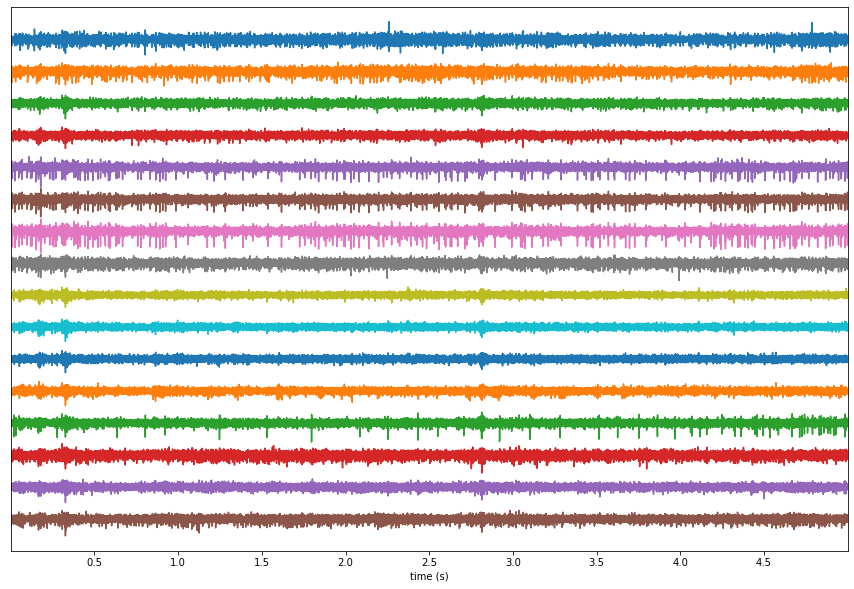

In [15]:
neuroData = adc_data[:16,:]
recording = se.NumpyRecordingExtractor(timeseries=neuroData,sampling_frequency=Fs)
recording.load_probe_file('tetrode_16.prb')
recording_f = st.preprocessing.bandpass_filter(recording, freq_min=300, freq_max=6000)
fig,ax = plt.subplots(figsize=(15,10))
sw.plot_timeseries(recording_f,trange=[0,5],ax=ax);

In [16]:
# sorting
%env TEMPDIR=C:\tmp
ms4_params = ss.get_default_params('mountainsort4')
ms4_params['curation']=True
ms4_params['adjust_radius']  = 100
sorting_MS4_2 = ss.run_mountainsort4(recording=recording,output_folder='sorting_tmp',verbose=True)

env: TEMPDIR=C:\tmp
WARNING! No channel location given. Add dummy location.
Using 2 workers.
Using tmpdir: C:\tmp\tmpwmx81jmd
Num. workers = 2
Preparing C:\tmp\tmpwmx81jmd/timeseries.hdf5...
'end_frame' set to 9217280
Preparing neighborhood sorters (M=16, N=9217280)...
Preparing output...
Done with ms4alg.
Cleaning tmpdir::::: C:\tmp\tmpwmx81jmd
mountainsort4 run time 102.58s


In [17]:
# curation
sorting_ms4_curated = st.curation.threshold_snrs(sorting=sorting_MS4_2, recording = recording,
  threshold = 4, threshold_sign='less',
    max_snr_spikes_per_unit=100, apply_filter=False) #remove when less than threshold
print(sorting_ms4_curated.get_unit_ids())

sorting_ms4_curated=st.curation.threshold_firing_rates(sorting_ms4_curated,
    threshold=0.5, threshold_sign='less', duration_in_frames=recording.get_num_frames())
print(sorting_ms4_curated.get_unit_ids())

sorting_ms4_curated=st.curation.threshold_isi_violations(sorting_ms4_curated, 
    threshold = 0.9,duration_in_frames=recording.get_num_frames(), threshold_sign='greater' )
print(sorting_ms4_curated.get_unit_ids())

[4, 5, 8, 10, 11, 16, 25, 26, 32]
[4, 5, 8, 10, 11, 16, 25, 26, 32]
[4, 5, 8, 10, 11, 16, 25, 26, 32]


In [18]:
time_bin_start = 0
start_timestamp = 0

bins = np.arange(time_bin_start, adc_data.shape[1]/Fs, time_bin )

# extract the spike train, and bin it in time
spiketrain = []
for i in sorting_ms4_curated.get_unit_ids():
    spk_train = sorting_ms4_curated.get_unit_spike_train(i)
    spk_train = (spk_train - start_timestamp)/Fs #convert to s
    spiketrain.append(np.histogram(spk_train,bins)[0])

spiketrain_ms4=np.stack(spiketrain)   

[[1.         0.03981048]
 [0.03981048 1.        ]]


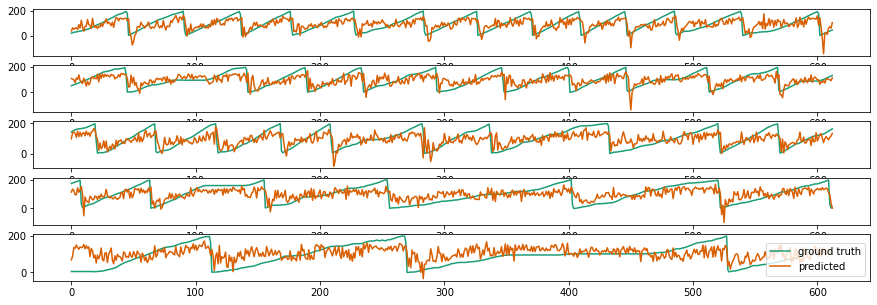

In [24]:
scaler =preprocessing.StandardScaler()
norm_spiketrain_ms4 = scaler.fit_transform(spiketrain_ms4.T)

norm_pos = np.round((position-position.min())/(position.max()-position.min())*200)

datalength = min(norm_spiketrain_ms4.shape[0], norm_pos.shape[0])
norm_spiketrain_ms4 = norm_spiketrain_ms4[:datalength,:]
norm_pos = norm_pos[:datalength]

poly_spiketrain_ms4 = preprocessing.PolynomialFeatures(2).fit_transform(norm_spiketrain_ms4)
# poly_spiketrain_ms4 = polyFeatures_ms4.transform(norm_spiketrain_ms4)
lasso_ms4 = linear_model.Lasso(alpha=0.1).fit(poly_spiketrain_ms4,norm_pos)

predicted_ms4 = model_selection.cross_val_predict(lasso_ms4,poly_spiketrain_ms4,norm_pos,cv=4)
bestCoeff_ms4 = np.corrcoef(norm_pos.squeeze(),predicted_ms4)
print(bestCoeff)

stripplot(norm_pos,predicted_ms4);

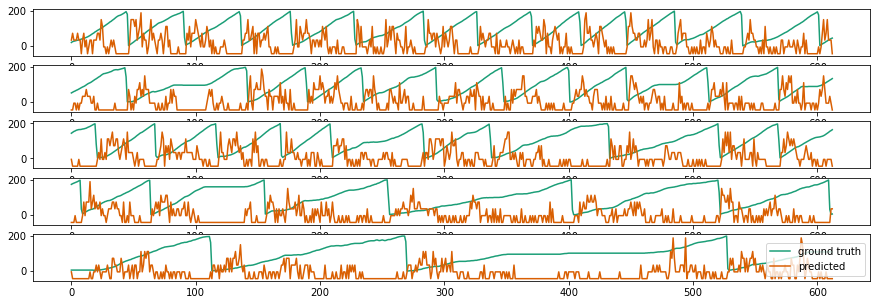

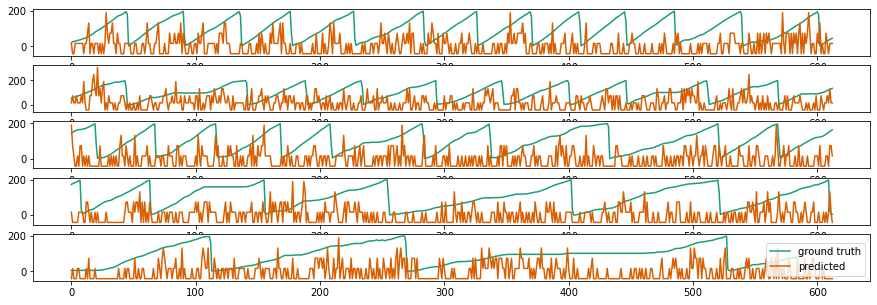

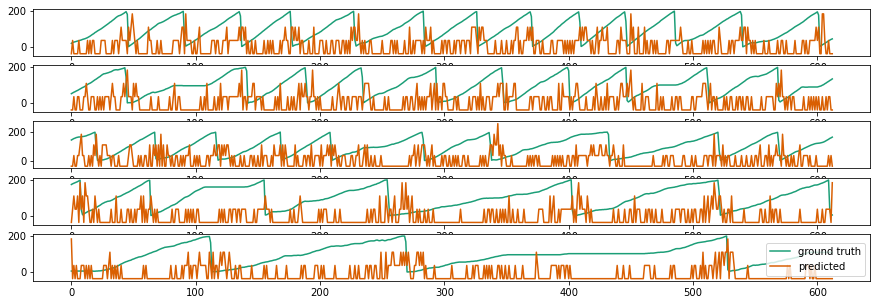

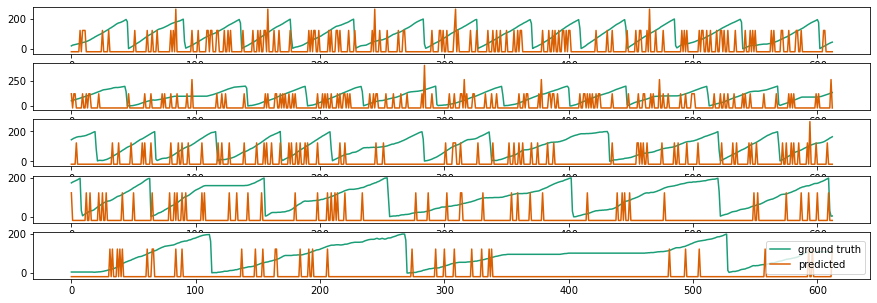

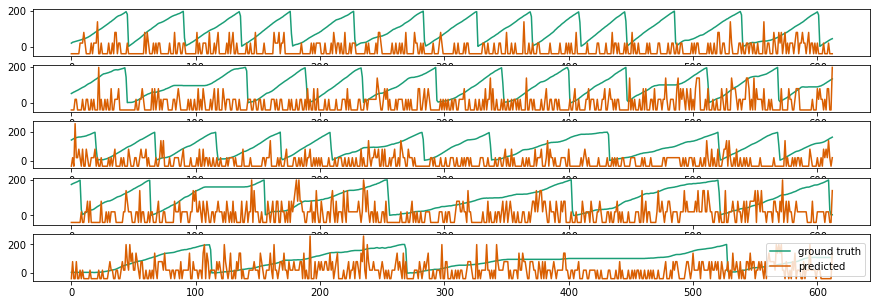

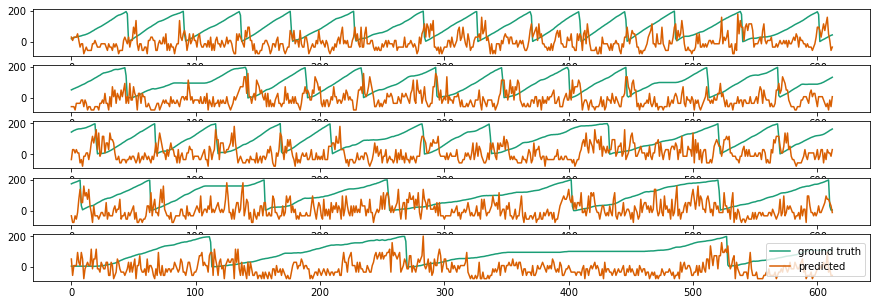

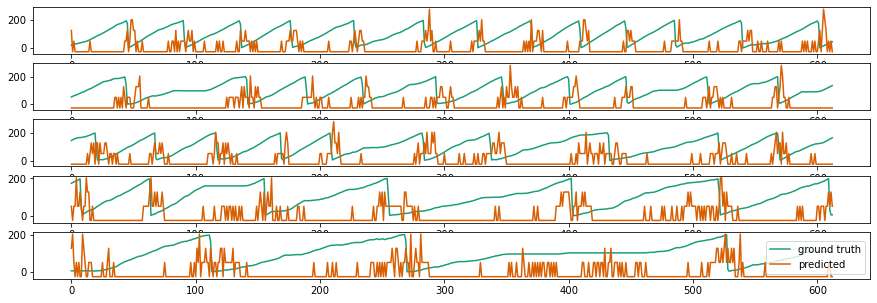

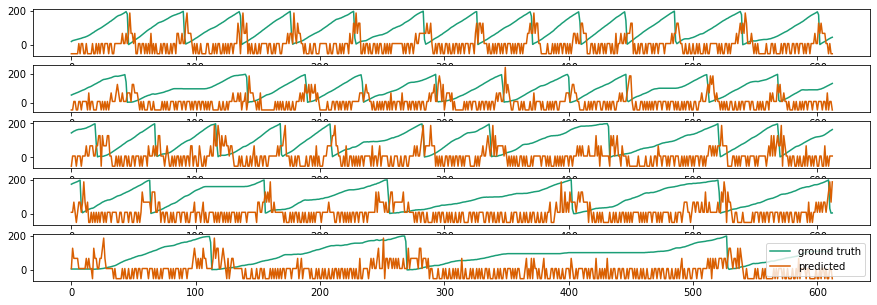

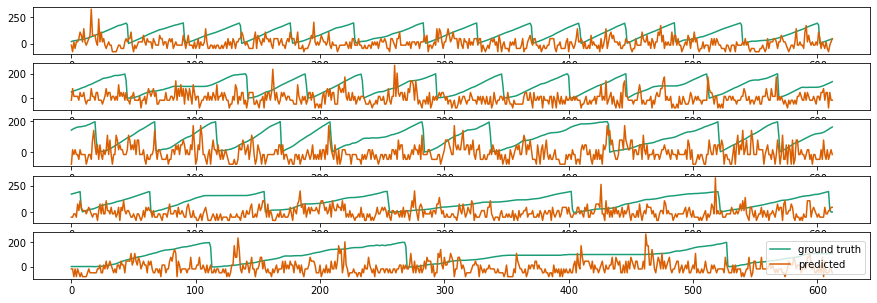

In [25]:
for i in range(norm_spiketrain_ms4.shape[1]):
    stripplot(norm_pos,norm_spiketrain_ms4[:,i]*50);

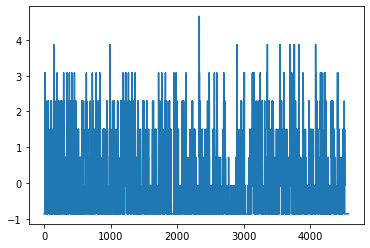

In [43]:
plt.plot(norm_spiketrain_ms4[:,2])

In [44]:
df_decoded = pd.read_pickle('data/decoded_data.pkl')

In [47]:
df_decoded.sort_values('meanScore',ascending=False)

model                                  sortedFeatureName  \
112  Lasso(alpha=0.1)  [x2, x0, x3, x10, x12, x2^2, x9, x13, x15, x2 ...   
120  Lasso(alpha=0.1)  [x2, x14, x9, x8, x2^2, x2 x14, x3, x14^2, x9 ...   
97   Lasso(alpha=0.1)  [x3, x15, x16, x3^2, x3 x16, x14, x17, x19, x2...   
121  Lasso(alpha=0.1)  [x15, x16, x5 x15, x10, x1, x10 x14, x13 x15, ...   
105  Lasso(alpha=0.1)  [x8, x3, x0, x4, x0 x5, x5 x8, x8^2, x3 x8, x2...   
..                ...                                                ...   
0    Lasso(alpha=0.1)                                      [x0, x0^2, 1]   
94   Lasso(alpha=0.1)  [x5, x2, x6, x4, x1, x5 x8, x5^2, x8, x6 x8, x...   
31   Lasso(alpha=0.1)  [x4, x2, x3, x1, x5, x5^2, x1 x3, x2^2, x3 x5,...   
84   Lasso(alpha=0.1)  [x12, x7, x13, x8, x10, x7 x12, x5, x6, x11, x...   
48   Lasso(alpha=0.1)  [x11, x10, x9, x2, x1, x5, x0, x2 x9, x3, x4, ...   

       meanScore                                             scores  \
112     0.390540  [0.20939310126147365, 0.26086171584513046, 0.2...   
120     0.370806  [0.18506497320448698, 0.18449288057857466, 0.2...   
97      0.334787  [0.24008593355009583, 0.25857119736991124, 0.2...   
121     0.331282  [0.11670965287913677, 0.1333439467175645, 0.16...   
105     0.293779  [0.1996118438120077, 0.1989804616260172, 0.250...   
..           ...                                                ...   
0    -283.903591         [-241.30446237785492, -283.90359116203456]   
94   -453.546058  [-214.41636449955573, -453.5460576483923, -470...   
31   -493.398021  [-261.2327942672108, -493.398021304907, -772.6...   
84  -2940.240539  [-2447.0034090795916, -2456.564698315384, -226...   
48  -5618.663693  [-5825.793639835601, -5109.367871926325, -5618...   

     bestNumfeature                                session  
112              66    cohort_4:M2_D23_2019-04-03_13-34-00  
120             101    cohort_4:M2_D25_2019-04-05_12-44-59  
97               85    cohort_4:M2_D24_2019-04-04_13-22-05  
121              98    cohort_4:M2_D27_2019-04-09_13-04-27  
105              28    cohort_4:M2_D16_2019-03-25_13-22-42  
..              ...                                    ...  
0                 1  cohort_2:1124_D10_2018-10-29_11-12-49  
94                1    cohort_3:M1_D21_2018-10-16_11-54-11  
31                1    cohort_2:245_D3_2018-10-20_10-56-04  
84                3    cohort_3:M1_D25_2018-10-19_13-01-11  
48                2     cohort_3:M1_D7_2018-09-14_13-13-03  

[152 rows x 6 columns]

In [54]:
df_decoded[df_decoded.session.str.match('.*M1_D4.*')]

model                                  sortedFeatureName  \
92  Lasso(alpha=0.1)  [x2, x1, x1 x2, x3, x1 x3, x2^2, x3^2, x0 x2, ...   

    meanScore                                             scores  \
92   0.021963  [0.01994906820348765, 0.02211494862908987, 0.0...   

    bestNumfeature                             session  
92               2  cohort_3:M1_D4_2018-09-09_12-09-53

## tuning curves

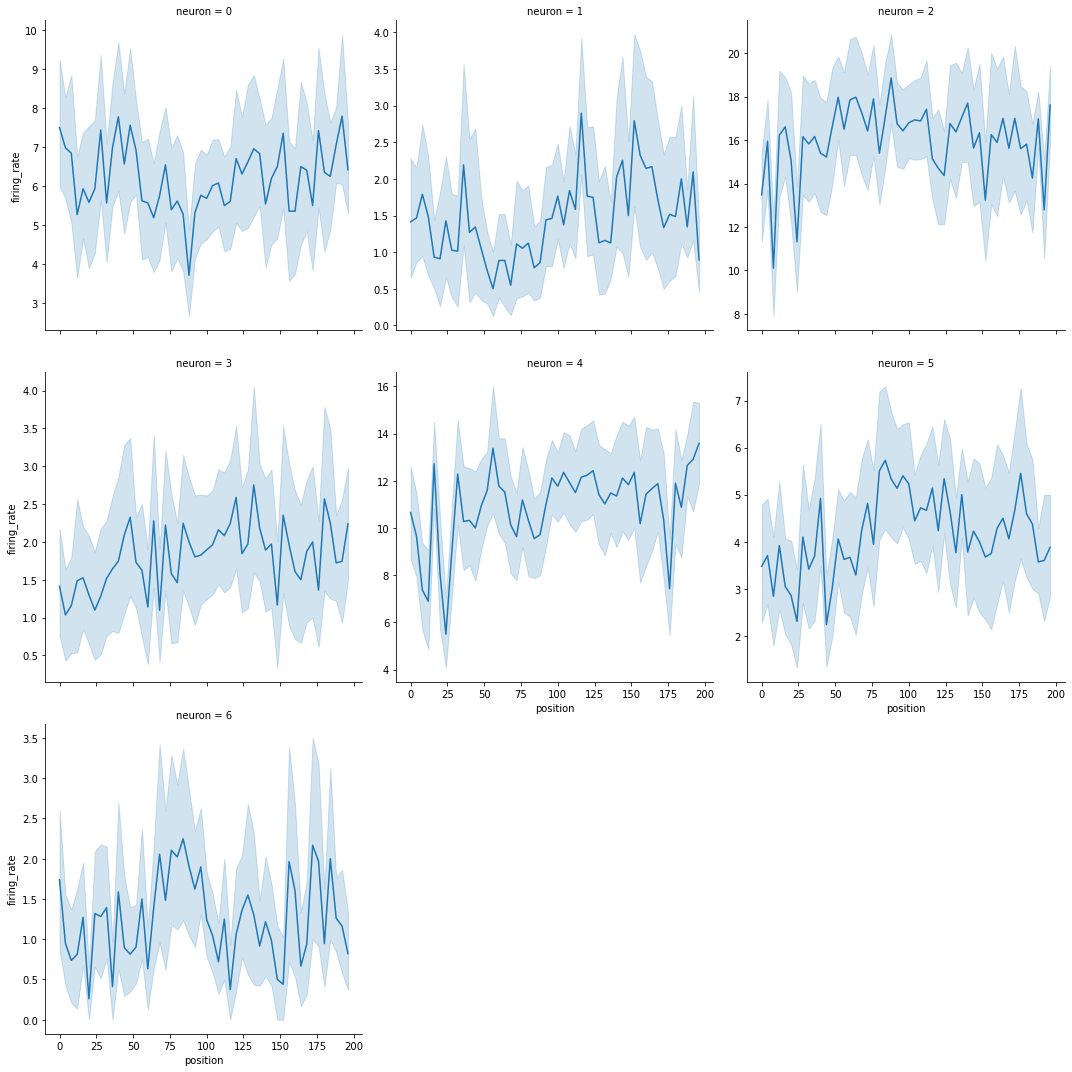

In [140]:
# calculate tuning curve

df_online_tc = makeTuningDataframe(position,spk_train.T,time_bin)

sns.relplot(x='position',y='firing_rate',col='neuron',col_wrap=3, kind="line",
    facet_kws = {'sharey':False},data=df_online_tc)


R[write to console]: `geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



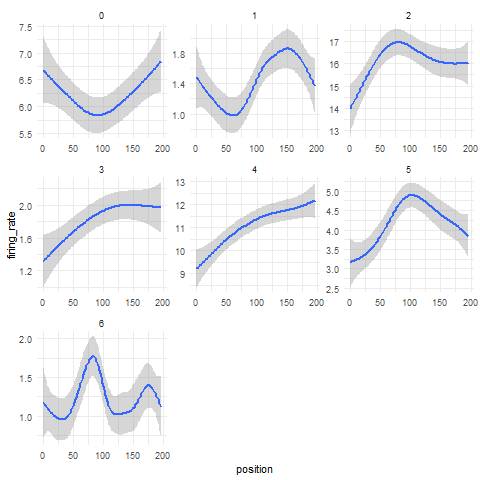

In [141]:
%%R -i df_online_tc
ggplot(df_online_tc) +
    geom_smooth(aes(x=position,y=firing_rate)) +
    facet_wrap(~neuron,scale='free') +
    theme_minimal()
# ggsave('online_tuningcurve.pdf')

## Offline sorting using spike interface

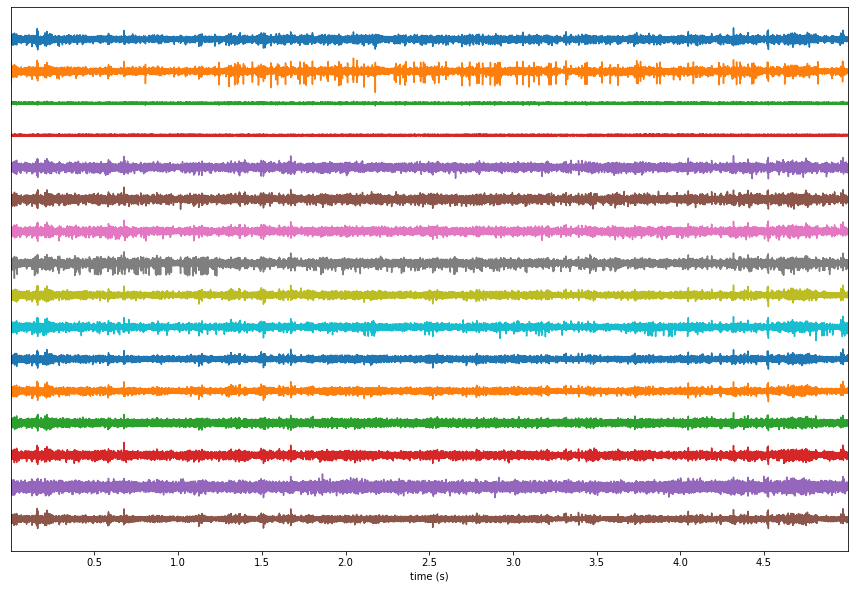

In [142]:
neuroData = adc_data[:16,:]
recording = se.NumpyRecordingExtractor(timeseries=neuroData,sampling_frequency=Fs)
recording.load_probe_file('tetrode_16.prb')
recording_f = st.preprocessing.bandpass_filter(recording, freq_min=300, freq_max=6000)
fig,ax = plt.subplots(figsize=(15,10))
sw.plot_timeseries(recording_f,trange=[0,5],ax=ax);

In [143]:
 #required for mountasort to store intermediate data
%env TEMPDIR=C:\tmp
ms4_params = ss.get_default_params('mountainsort4')
ms4_params['curation']=True
ms4_params['adjust_radius']  = 100
sorting_MS4_2 = ss.run_mountainsort4(recording=recording,output_folder='sorting_tmp',verbose=True)

env: TEMPDIR=C:\tmp
WARNING! No channel location given. Add dummy location.
Using 2 workers.
Using tmpdir: C:\tmp\tmp6fpmdcde
Num. workers = 2
Preparing C:\tmp\tmp6fpmdcde/timeseries.hdf5...
'end_frame' set to 13849600
Preparing neighborhood sorters (M=16, N=13849600)...
Preparing output...
Done with ms4alg.
Cleaning tmpdir::::: C:\tmp\tmp6fpmdcde
mountainsort4 run time 145.57s


In [144]:
# curation
sorting_ms4_curated = st.curation.threshold_snrs(sorting=sorting_MS4_2, recording = recording,
  threshold = 4, threshold_sign='less',
    max_snr_spikes_per_unit=100, apply_filter=False) #remove when less than threshold
print(sorting_ms4_curated.get_unit_ids())

sorting_ms4_curated=st.curation.threshold_firing_rates(sorting_ms4_curated,
    threshold=0.5, threshold_sign='less', duration_in_frames=recording.get_num_frames())
print(sorting_ms4_curated.get_unit_ids())

sorting_ms4_curated=st.curation.threshold_isi_violations(sorting_ms4_curated, 
    threshold = 0.9,duration_in_frames=recording.get_num_frames(), threshold_sign='greater' )
print(sorting_ms4_curated.get_unit_ids())


Impossible to delete temp file: C:\Users\teristam\AppData\Local\Temp\tmpbjb6p_g6 Error [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\teristam\\AppData\\Local\\Temp\\tmpbjb6p_g6\\waveforms_1.raw'
[2, 4, 8, 9, 10, 12, 14, 15, 17, 20, 22, 23, 26, 27]
[2, 4, 8, 9, 10, 12, 14, 15, 17, 20, 22, 23, 26, 27]
[2, 4, 8, 9, 10, 12, 14, 15, 17, 20, 22, 23, 26, 27]


In [145]:
time_bin_start = 0
bins = np.arange(time_bin_start, adc_data.shape[1]/Fs, time_bin )

# extract the spike train, and bin it in time
spiketrain = []
for i in sorting_ms4_curated.get_unit_ids():
    spk_train = sorting_ms4_curated.get_unit_spike_train(i)
    spk_train = (spk_train - start_timestamp)/Fs #convert to s
    spiketrain.append(np.histogram(spk_train,bins)[0])

spiketrain=np.stack(spiketrain)    

# make frame for plotting
df_ms4 = makeTuningDataframe(position, spiketrain.T,time_bin)


R[write to console]: `geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



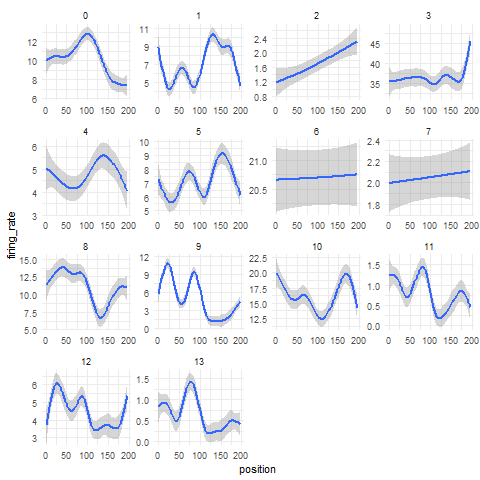

In [146]:
%%R -i df_ms4
options(repr.plot.width=12, repr.plot.height=8)

ggplot(df_ms4) +
    geom_smooth(aes(x=position,y=firing_rate)) +
    facet_wrap(~neuron,scale='free') +
    theme_minimal()
    
# ggsave('ms4_tuningcurve.pdf')